In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [6]:
df= pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv', parse_dates=['date'], index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 230130 entries, 2010-01-01 to 2016-12-31
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   country   230130 non-null  object 
 2   store     230130 non-null  object 
 3   product   230130 non-null  object 
 4   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 10.5+ MB


# Preprocessing Data and EDA

In [10]:
#fill in missing values with mean
df['num_sold'].fillna(df['num_sold'].mean(), inplace=True)

df = df[df.index >= '2011-01-01']  # Exclude data before January 1, 2011 becuase data is incomplete for 2010
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2011-01-01 to 2016-12-31
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   num_sold  2192 non-null   float64
dtypes: float64(1)
memory usage: 34.2 KB


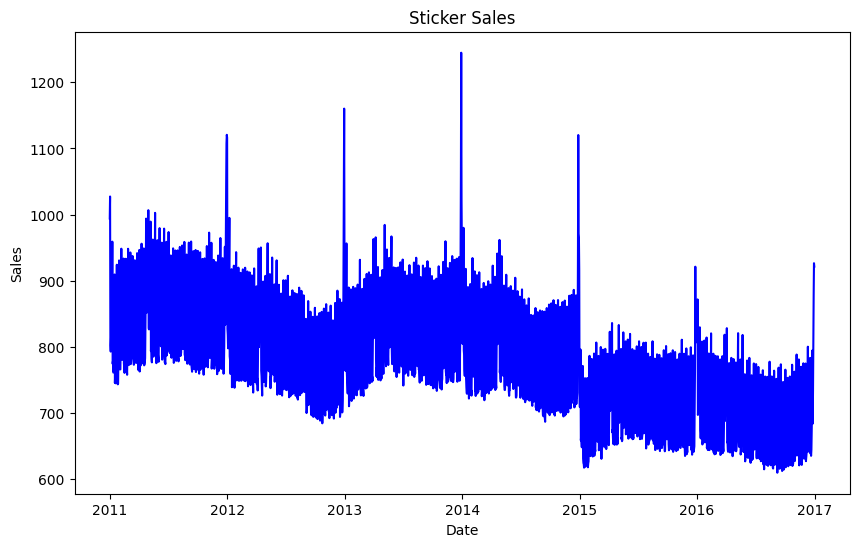

In [11]:
#Aggregating sticker sales by day 
df=df.resample('D').agg({'num_sold': 'mean'})

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot( df['num_sold'], color='blue')
plt.title('Sticker Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

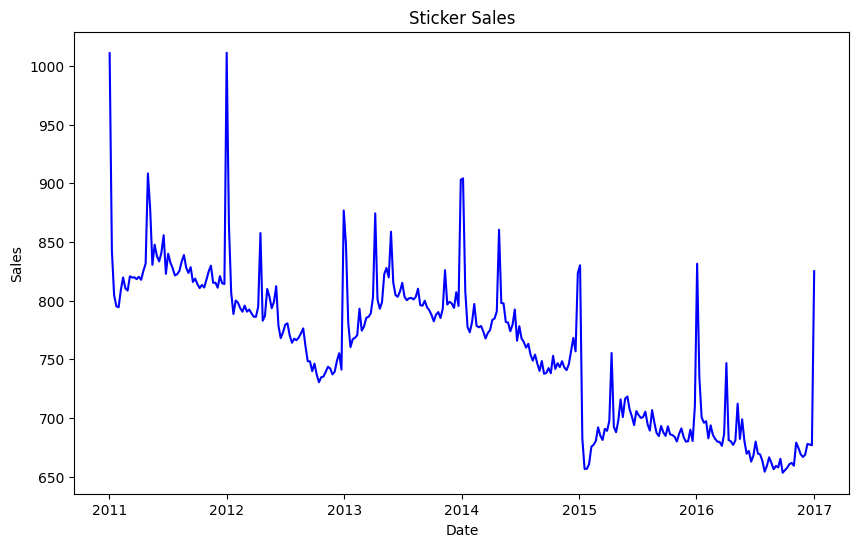

In [12]:
#Transforming the daily data into weekly data by taking the average
df=df.resample('W').agg({'num_sold': 'mean'})

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot( df['num_sold'], color='blue')
plt.title('Sticker Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [13]:
# Define a specific date to split the data
split_date = '2016-01-07'

# Split the data based on the date
train = df[df.index <= split_date]
test = df[df.index >= split_date]

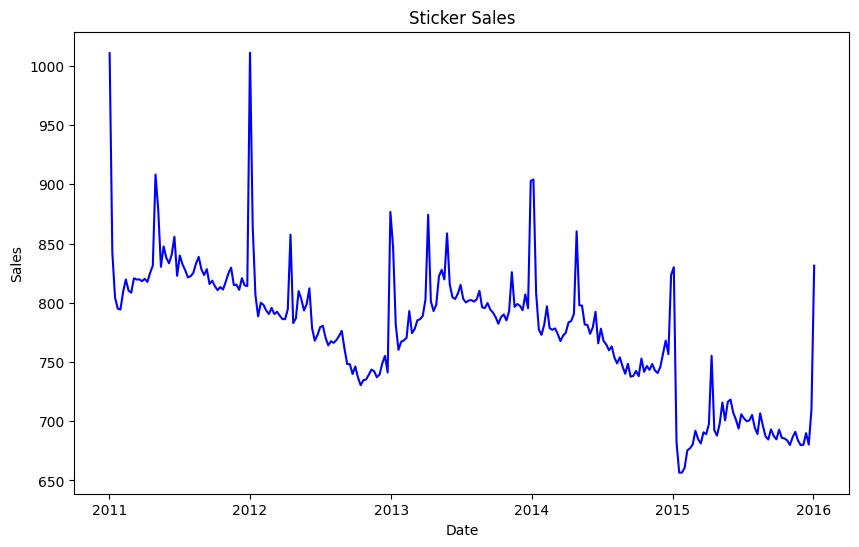

In [14]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot( train['num_sold'], color='blue')
plt.title('Sticker Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [15]:
# Stationarity check (Augmented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['num_sold'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Consider differencing.")


ADF Statistic: -1.8471354831123439
p-value: 0.3573238417374776
The data is not stationary. Consider differencing.


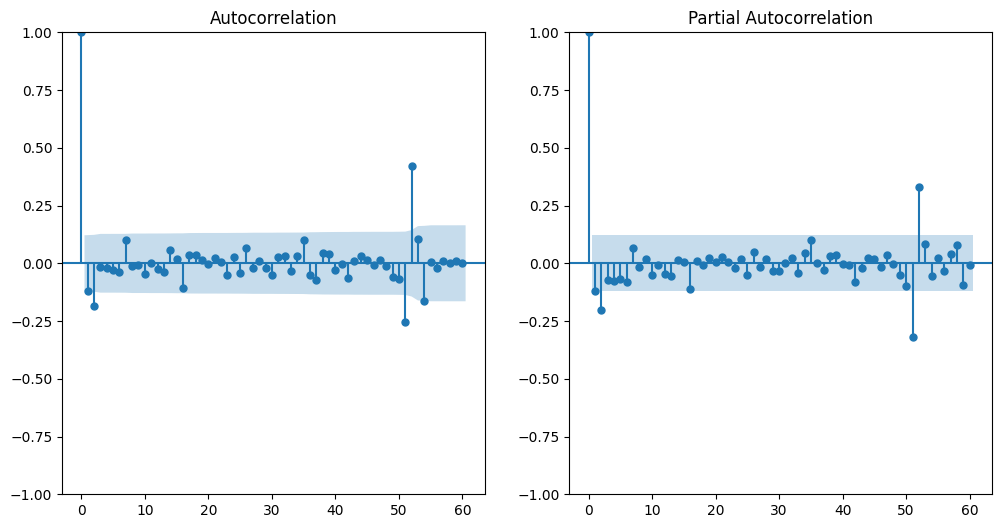

In [16]:
#differencing the data
df_diff = train['num_sold'].diff().dropna()

# Plot ACF and PACF to identify p, d, q
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(df_diff, ax=plt.gca(), lags=60)

plt.subplot(122)
plot_pacf(df_diff, ax=plt.gca(), lags=60)

plt.show()

# Building the model

Based on Autocorrelation and Partial Autocorrelation graph, up to 52 lags should be included in the model. This agrees with the yearly trends shown in the plots earlier.  

In [20]:
# Fit ARIMA model 
p, d, q = 52, 1, 10 
model = ARIMA(train['num_sold'], order=(p, d, q))
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


After hypermeter tuning, it was found that lower lags for moving average part of the model performed better. 

# Evaluating the model

In [21]:
# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Evaluate the model (Mean Squared Error)
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error (MSE): {mse}')


Mean Squared Error (MSE): 728.9711543879141


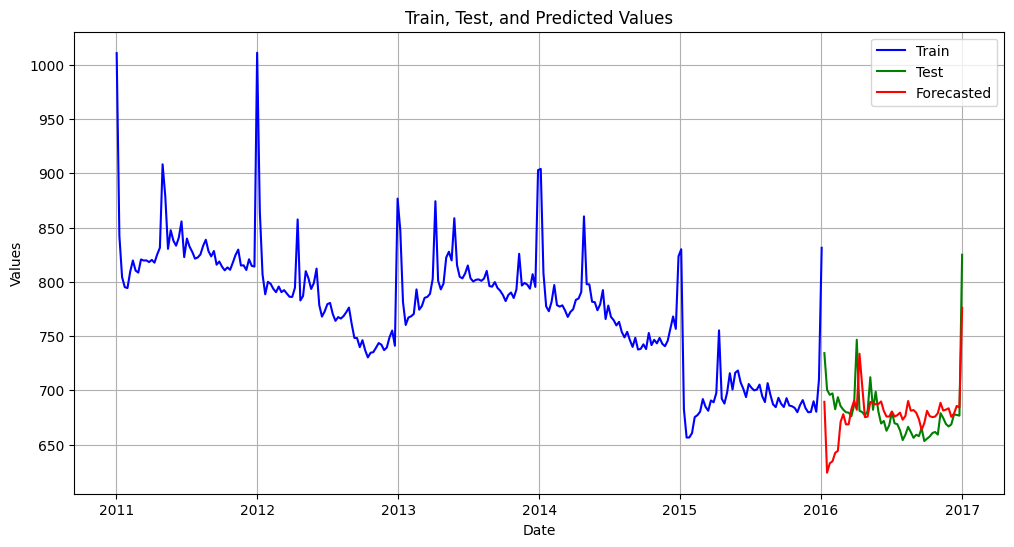

In [22]:
forecast = model_fit.forecast(steps=len(test))

# Plotting the training set, test set, and predicted values
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train['num_sold'], label='Train', color='blue')

# Plot test data
plt.plot(test.index, test['num_sold'], label='Test', color='green')

# Plot forecasted values
plt.plot(test.index, forecast, label='Forecasted', color='red')

# Add labels and title
plt.title('Train, Test, and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

The forecasted sticker sales generally followed the same pattern as the train and test data from year to year. Overall, the time series analysis shows a decreasing trend. 